In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ccxt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
# Configuración de GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Fuente de los datos
exchange = ccxt.binance()

# Obtener datos históricos
symbol = 'BTC/MXN'
timeframe = '1h'
since = exchange.parse8601('2023-10-01T00:00:00Z')
limit = 1000
ohlc = exchange.fetch_ohlcv(symbol, timeframe, since, limit)

In [69]:
# Convertir a DataFrame
df = pd.DataFrame(ohlc,
    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.head())

                          open       high        low      close    volume
timestamp                                                                
2024-05-29 15:00:00  1152513.0  1222880.0  1149898.0  1154680.0  0.178535
2024-05-29 16:00:00  1151976.0  1153714.0  1150730.0  1150730.0  0.016489
2024-05-29 17:00:00  1149953.0  1156310.0  1149953.0  1155403.0  0.001466
2024-05-29 18:00:00  1144952.0  1147208.0  1144952.0  1147208.0  0.038433
2024-05-29 19:00:00  1150475.0  1153626.0  1147208.0  1147208.0  0.020860


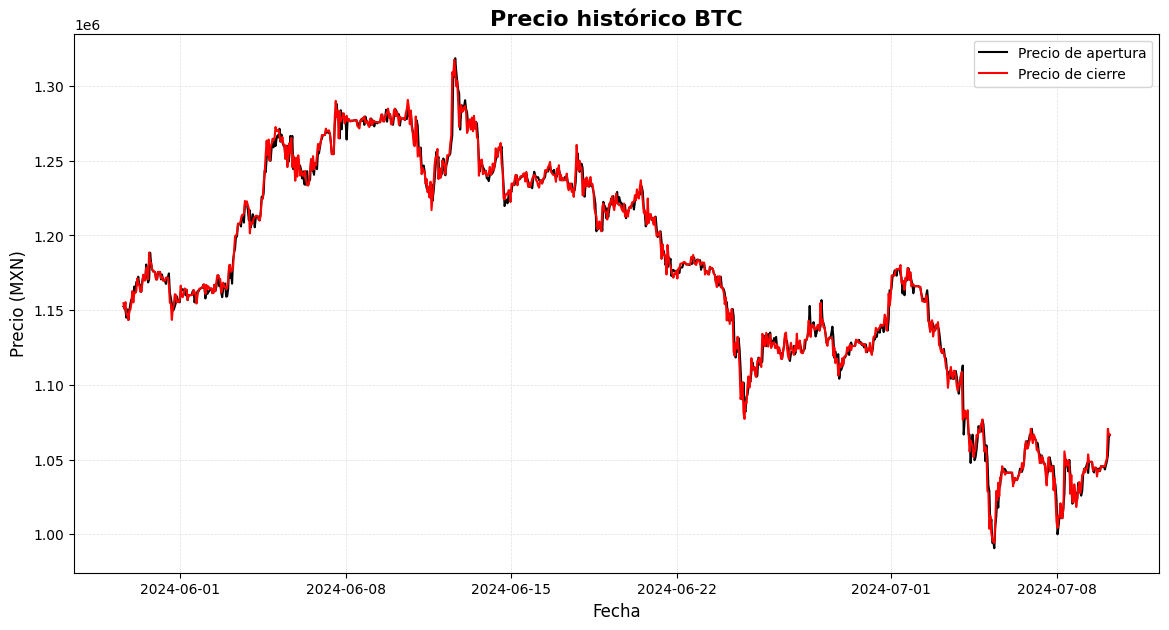

In [70]:
# Ver los datos
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["open"], label="Precio de apertura",
    color='black', linewidth=1.5)
plt.plot(df.index, df["close"], label="Precio de cierre",
    color='red', linewidth=1.5)
plt.title("Precio histórico BTC", fontsize=16, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio (MXN)", fontsize=12)
plt.legend()
plt.grid(visible=True, color='lightgrey', linestyle='--',
    linewidth=0.5, alpha=0.7)
plt.show()

In [45]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['close']])
print(df_scaled[:5])

[[0.49618384]
 [0.48396843]
 [0.49841973]
 [0.47307661]
 [0.47307661]]


In [46]:
# Preparar los datos en secuencias
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])
X, y = np.array(X), np.array(y)
print(X[0][:5])

[0.49618384 0.48396843 0.49841973 0.47307661 0.47307661]


In [47]:
# Dividir en conjuntos de entrenamiento (80%) y prueba (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train[0][:5])

[0.49618384 0.48396843 0.49841973 0.47307661 0.47307661]


In [53]:
# Transformar en un formato compatible con el modelo LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train[0][:5])

[[0.49618384]
 [0.48396843]
 [0.49841973]
 [0.47307661]
 [0.47307661]]


In [54]:
# Construcción del modelo LSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1)) # Predicción de un solo valor
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# Entrenamiento del modelo
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1298
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0035
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoc

In [66]:
# Predicción en el conjunto de prueba
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
print(predicted_price[:5])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[1163018.2]
 [1161763.6]
 [1160810.6]
 [1159977.8]
 [1158487.9]]


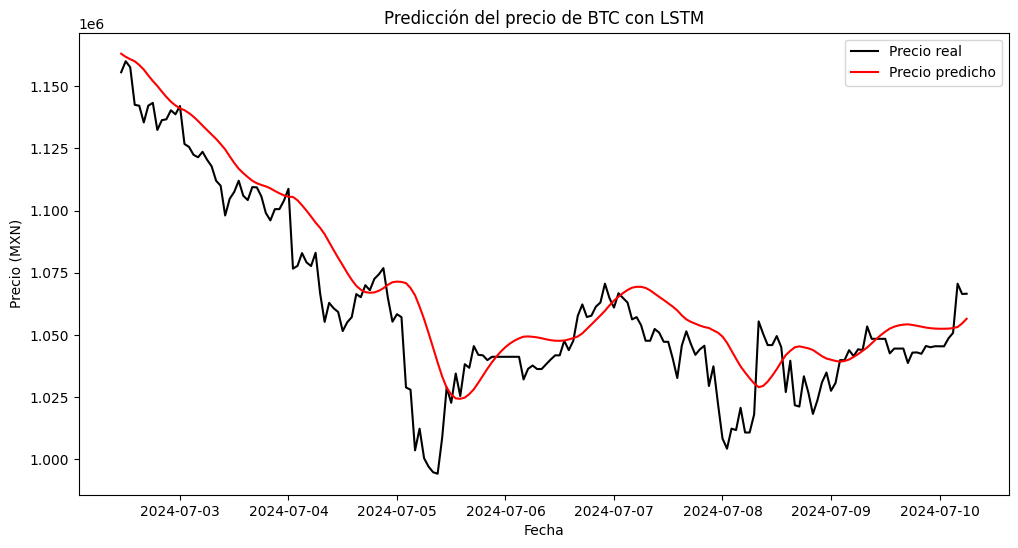

In [71]:
# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + sequence_length:], y_test_original,
    color = 'black', label='Precio real')
plt.plot(df.index[train_size + sequence_length:], predicted_price,
    color='red', label='Precio predicho')
plt.title("Predicción del precio de BTC con LSTM")
plt.xlabel("Fecha")
plt.ylabel("Precio (MXN)")
plt.legend()
plt.show()

In [72]:
# Evaluar el modelo
mse = mean_squared_error(y_test_original, predicted_price)
mae = mean_absolute_error(y_test_original, predicted_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predicted_price)
mape = np.mean(
    np.abs((y_test_original - predicted_price) / y_test_original)) * 100

# Imprimir las métricas
print(f"Error cuadrático promedio (MSE): {mse:.2f}")
print(f"Error absoluto promedio (MAE): {mae:.2f}")
print(f"Raíz del error cuadrático promedio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")
print(f"Error porcentual absoluto promedio (MAPE): {mape:.2f}%")

Error cuadrático promedio (MSE): 301600728.09
Error absoluto promedio (MAE): 13168.08
Raíz del error cuadrático promedio (RMSE): 17366.66
Coeficiente de determinación (R²): 0.77
Error porcentual absoluto promedio (MAPE): 1.26%
